80.0
0.0


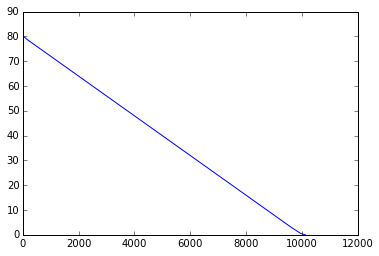

2.0


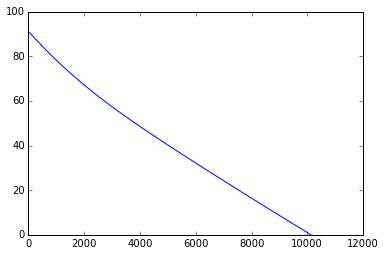

4.0


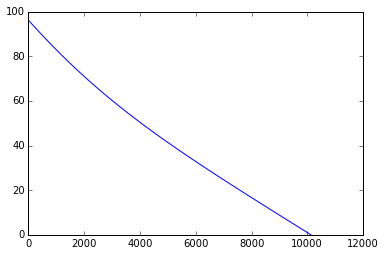

6.0


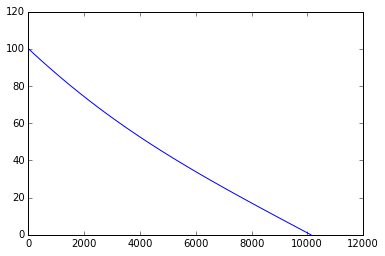

8.0


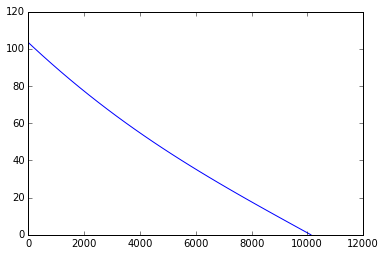

10.0


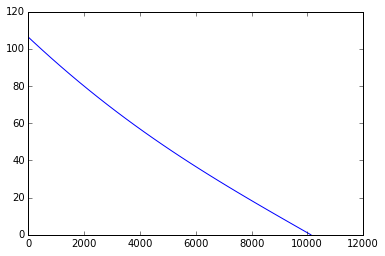

In [45]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

friction = 'Manning'

Qf = 70. # characteristic flood discharge
If = 0.03 # flood intermittency
B = 25. # channel width
D = 30. # characteristic diameter of sediment
D_ = float(D)/1000
porosity = 0.35
kc = 75.
kc_ = kc/1000
S = 0.008
Gtf =  700000. # imposed annual sediment transport reach
L = 10000. # length of fluvial reach

M = 60 # number of sub-reaches

dx = int(L / M)
dt = 0.01 # years
totalT = 10. # number of timesteps per printout * number of printouts / dt

alpha_u = 0.5 # upwind coefficient [1=full upwind, 0.5=central difference]
phis = 1. # boundary shear stress due to skin friction (phi <= 1)
alpha_r = 8.1 # coefficient in Manning resistance relation

# parameters for load relation (Wong and Parker, 2006)
alpha_t = 8. # coefficient in sed transport relation
tau_c = 0.047
nt = 1.5 # exponent in sed transport relation

# Chezy
Cf = 22.

# Constants
g = 9.81
rho_w = 1000.
rho_s = 2650.
sec_to_year = 60 * 60 * 24 * 365.25

# Derivatives
R = (float(rho_s) - float(rho_w)) / float(rho_w)

# arrays
x = np.array(range(M+2)) * dx
eta = S*L - S*x
eta[-1] = 0



# ambient equilibria

if friction == 'Manning':
    He = (Qf**2 * kc_**(1./3) / (alpha_r**2 * g * S * B**2))**(0.3) #############

if friction == 'Chezy':
    He = (Qf**2 * Cf / (g * S * B**2)) ** (1./3)
    
taustar = He * S / (R * D_)
qstar = 0

if (phis * taustar) > tau_c:
    qstar = alpha_t * (phis * taustar - tau_c)**nt
    qt = qstar * sqrt(g * R * D_) * D_
    Gt = qt * B * (1+R) * If * sec_to_year


    
    
    
    
    
    
    
# ultimate equilibria

qtf = Gtf / (B * (1+R) * If * sec_to_year)
tauult = (tau_c + (qtf / (alpha_t * sqrt(g * R * D_) * D_))**(1/nt)) / phis

if friction == 'Manning':
    
    Sult = (R * D_ * tauult)**(10./7.) * \
        ( alpha_r**2 * B**2 * g / (Qf**2 * kc_**(1./3)) )**(3./7.)

if friction == 'Chezy':
    
    Sult = (R * D_ * tauult * (g * B**2 / (Qf**2 * Cf))**(1./3))**1.5
    
Hult = R * D_ * tauult / Sult




qb = np.zeros((M+2,), dtype = np.float)
Sl = np.zeros_like(qb)
tau = np.zeros_like(qb)
Ht = np.zeros_like(qb)

print max(eta)

for t in np.arange(0, totalT+dt, dt):
    
# #     if (t)%1 == 0:
#     print 10*'-'
#     print 'TIME:', t
    
    # run
    # findslopes

    Sl[0] = (eta[0] - eta[1]) / dx
    Sl[-1] = (eta[-2] - eta[-1]) / dx

    for i in range(1,len(Sl)-1):   
        Sl[i] = (eta[i-1] - eta[i+1]) / (2*dx)
        
#     if (t)%1 == 0:
#     print 'slope:', Sl[0]
        
    # finddepthshear

    if friction == 'Manning':   
        H = (Qf**2 * kc_**(1./3) / (alpha_r**2 * B**2 * g * Sl))**(3./10.)

    if friction == 'Chezy':
        H = (Qf**2 * Cf / (g * B**2 * Sl))**(1./3)
        
#     if (t)%1 == 0:
#     print 'H:', H[0]

    tau = H * Sl / (R * D_)
    
#     if (t)%1 == 0:
#     print 'tau:', tau[0]

    # findload

    load = phis * tau - tau_c
    load[load <= 0] = 0
    load[load > 0] = alpha_t * load[load > 0]**nt
    
#     if (t)%1 == 0:
#     print 'load:', load[0]
        
    qb = load * D_ * sqrt(R * g * D_)
#     if (t)%1 == 0:
#     print 'qb:', qb[0]

    
    # findneweta
    dq = np.zeros_like(qb)
    dq[0] = alpha_u * (qtf - qb[0]) / dx + \
                (1 - alpha_u) * (qb[0] - qb[1]) / dx

#     if (t)%1 == 0:
#     print 'qb0:', qb[0]
#     print 'qb1:', qb[1]
#     print 'dq0:', dq[0]
#     print 'dq(1):', alpha_u * (qtf - qb[0]) / dx
#     print 'dq(2):', (1 - alpha_u) * (qb[0] - qb[1]) / dx
        
    for i in range(1,M+1):   
        dq[i] = alpha_u * (qb[i-1] - qb[i]) / dx + \
                (1 - alpha_u) * (qb[i] - qb[i+1]) / dx

#     print 'eta1:', eta[0]
    eta = eta + (dt * sec_to_year / (1-porosity)) * If * dq
#     eta = eta + const * dq
    
#     print '(...):', (dt * sec_to_year / (1-porosity)) * If * dq[0]
    
#     if (t)%1 == 0:
#     print 'eta2:', eta[0]
    if (t)%2 == 0:
        
        print t
        plt.plot(x, eta)
        plt.show()

#         print t
#         print max(eta)